In [1]:
IMG_NAME = "real_test"
import os
try:
    os.mkdir(f"imgs/{IMG_NAME}")
    os.mkdir(f"imgs/{IMG_NAME}/tmp")
except FileExistsError:
    pass

In [2]:
from deskew import determine_skew
import numpy as np
import cv2
from typing import Union, Tuple
import math

def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [3]:
image = cv2.imread(f'imgs/{IMG_NAME}.jpg')
blur_image = cv2.GaussianBlur(image, (9,9), 0)
binary = cv2.cvtColor(blur_image, cv2.COLOR_BGR2GRAY)
binary = cv2.adaptiveThreshold(binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 5)
cv2.imwrite(f'imgs/{IMG_NAME}/binary.jpg', binary)

True

In [4]:
angle = determine_skew(binary)
rotated = rotate(binary, angle, (255,255,255))
cv2.imwrite(f'imgs/{IMG_NAME}/rotated.jpg', rotated)

True

In [5]:
def check_acc_range(value, mean, std, acc=1):
    return mean - acc * std < value < mean + acc * std

In [6]:
image.shape

(4000, 3000, 3)

In [7]:
mser = cv2.MSER_create()
# regions, _ = mser.detectRegions(canny)
regions, _ = mser.detectRegions(rotated)
rects = [cv2.boundingRect(p.reshape(-1, 1, 2)) for p in regions]
rects = list(set(rects))
margin_side = 10
margin_top = 0
width_avg = np.mean(list(map(lambda x: x[2], rects)))
width_std = np.std(list(map(lambda x: x[2], rects)))
height_avg = np.mean(list(map(lambda x: x[3], rects)))
height_std = np.std(list(map(lambda x: x[3], rects)))

rects = list(filter(lambda x: check_acc_range(x[2], width_avg, width_std) and check_acc_range(x[3], height_avg, height_std), rects))

merged_rects = []
rects = list(map(lambda y: (y[0]-margin_side, y[1]-margin_top, y[0]+y[2]+(2*margin_side), y[1]+y[3]+(2*margin_top)),sorted(rects, key=lambda x: x[1])))
margin_show = image.copy()
margin_show = rotate(margin_show, angle, (255,255,255))

for rect in rects:
    cv2.rectangle(margin_show, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)
cv2.imwrite(f'imgs/{IMG_NAME}/margin.jpg', margin_show)
for i, rect in enumerate(rects):
    j = i+1
    while j < len(rects):
        if rect[3] < rects[j][1]:
            break
        if (rect[0] <= rects[j][2] and rect[2] >= rects[j][0]) or (rect[2] >= rects[j][0] and rect[0] <= rects[j][2]):
            rect = (min(rect[0], rects[j][0]), min(rect[1], rects[j][1]), max(rect[2], rects[j][2]), max(rect[3], rects[j][3]))
            rects.pop(j)
            j = i
        j += 1
    merged_rects.append(rect)

copy = image.copy()
copy = rotate(copy, angle, (255,255,255))
for rect in merged_rects:
    cv2.rectangle(copy, (rect[0]+margin_side, rect[1]+margin_top), (rect[2]-margin_side, rect[3]-margin_top), (0, 255, 0), 2)
cv2.imwrite(f'imgs/{IMG_NAME}/merged_rects.jpg', copy)

True

In [8]:
def blur_data(data, length=3):
    blurred = []

    def average(data, start, end):
        total = 0
        for i in range(start, end+1):
            total += data[i]
        return total / (end - start + 1)
    
    for i in range(length // 2, len(data)- length // 2):
        blurred.append(average(data, i - length // 2, i + length // 2))

    for i in range(length // 2):
        blurred.insert(i, data[i])
        blurred.append(data[-i-1])

    return blurred

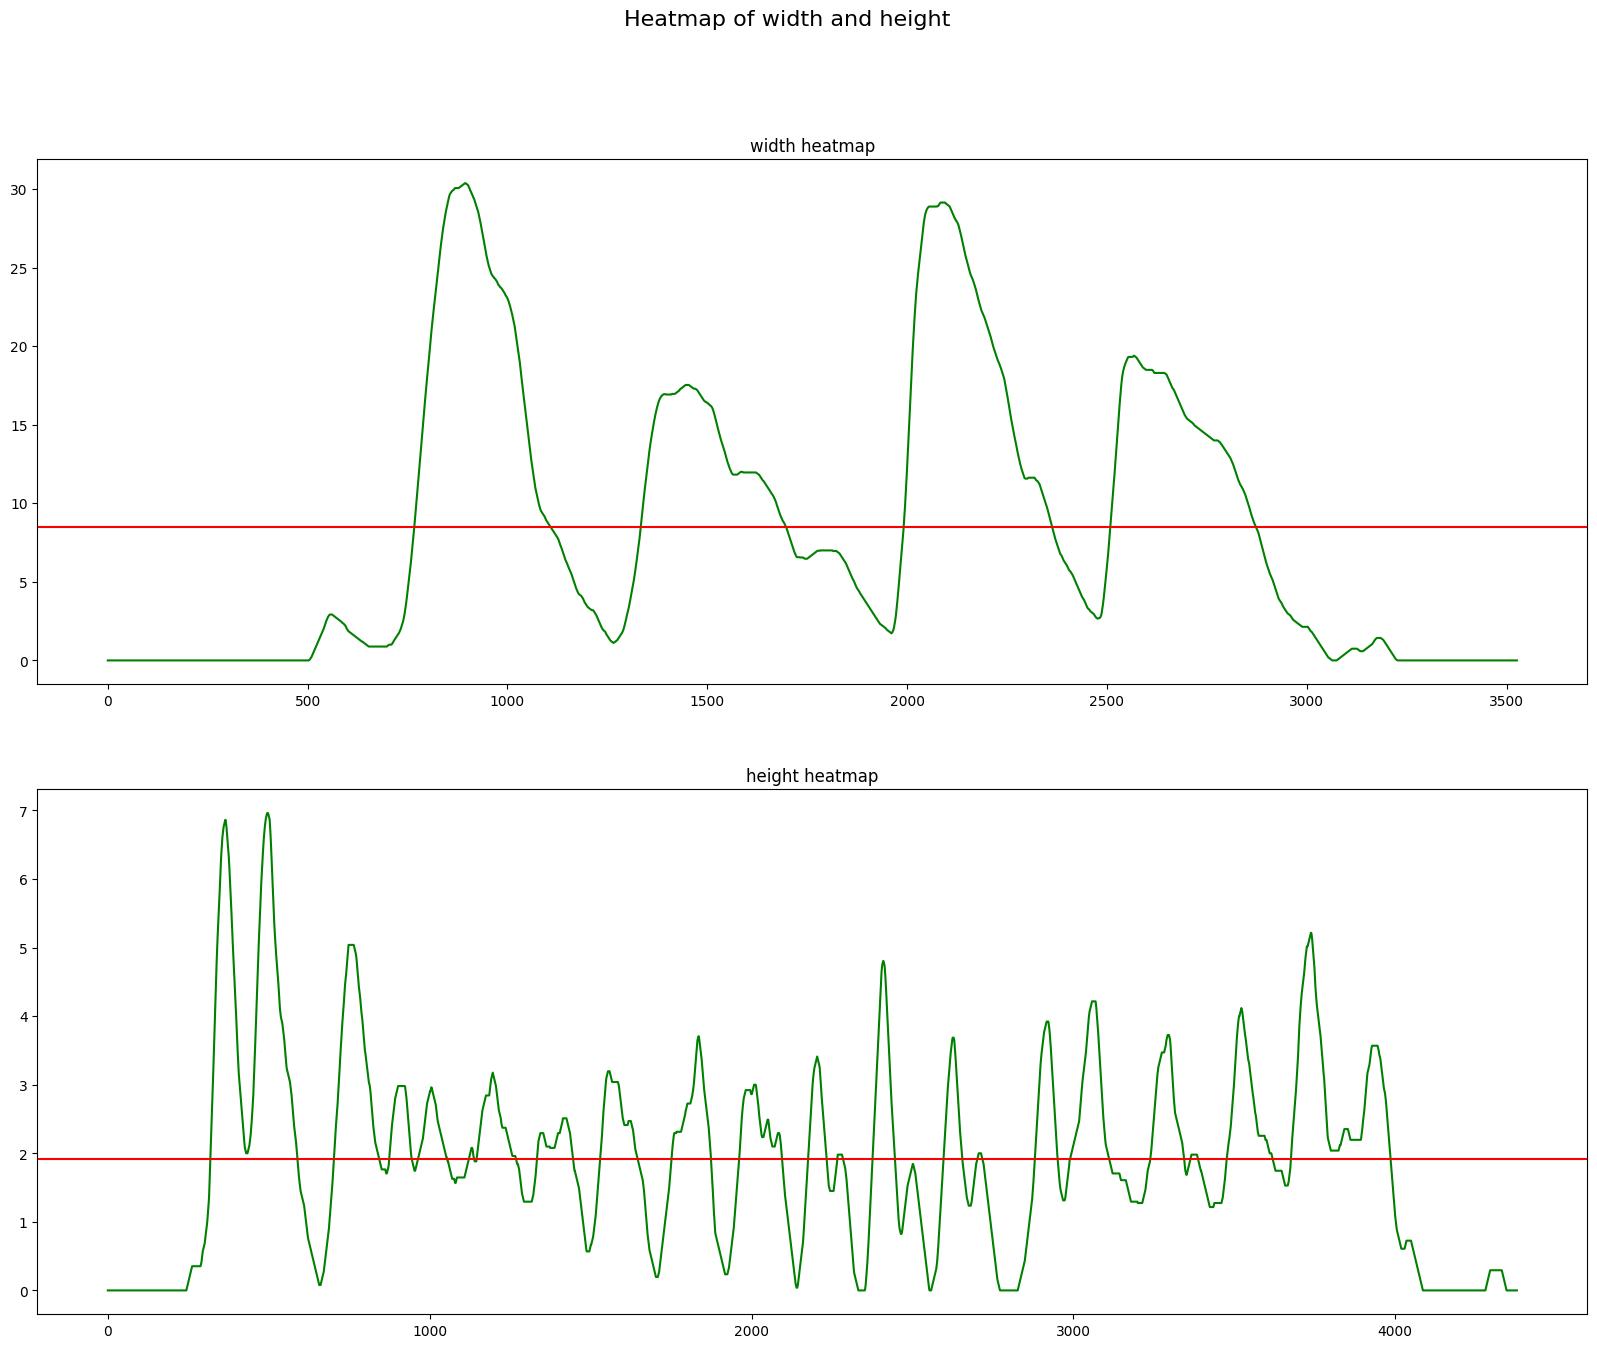

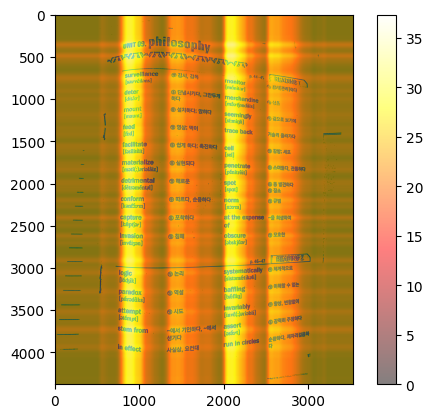

In [9]:
# array check
x_heatmap = [0 for _ in range(copy.shape[1])]
y_heatmap = [0 for _ in range(copy.shape[0])]

for (x1, y1, x2, y2) in merged_rects:
    x_heatmap[x1:x2] = [i + 1 for i in x_heatmap[x1:x2]]
    y_heatmap[y1:y2] = [i + 1 for i in y_heatmap[y1:y2]]

x_heatmap_avg = sum(x_heatmap) / len(x_heatmap)
x_heatmap_std = np.std(x_heatmap)
y_heatmap_avg = sum(y_heatmap) / len(y_heatmap)
y_heatmap_std = np.std(y_heatmap)

x_min = x_heatmap_avg #- x_heatmap_std
y_min = y_heatmap_avg #- y_heatmap_std

x_heatmap_0 = blur_data(x_heatmap, 51)
y_heatmap_0 = blur_data(y_heatmap, 51)

# show graph of width and height with matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Heatmap of width and height', fontsize=16)
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('width heatmap')
#ax1.plot(x_heatmap, color='b')
ax1.plot(x_heatmap_0, color='g')
ax1.axhline(y=x_min, color='r', linestyle='-', label='average')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('height heatmap')
#ax2.plot(y_heatmap, color='b')
ax2.plot(y_heatmap_0, color='g')
ax2.axhline(y=y_min, color='r', linestyle='-', label='average')
plt.show()

# show image with heatmap
import matplotlib.image as mpimg
img = mpimg.imread(f'imgs/{IMG_NAME}/rotated.jpg')
plt.imshow(img)
twoD_data = [[ 0 for _ in range(len(x_heatmap_0))] for _ in range(len(y_heatmap_0))]
for i in range(len(x_heatmap_0)):
    for j in range(len(y_heatmap_0)):
        twoD_data[j][i] = x_heatmap_0[i] + y_heatmap_0[j]
plt.imshow(twoD_data, alpha=0.5, cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
x_array_range = []
start = None
end = None
for i in range(0, len(x_heatmap)):
    if x_heatmap[i] >= x_min and start is None:
        start = i
    if x_heatmap[i] < x_min and start is not None:
        end = i
        x_array_range.append((start, end))
        start = None
        end = None

x_array_range

In [ ]:
images = []
base_image = image.copy()
base_image = rotate(base_image, angle, (255,255,255))
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
base_image = cv2.adaptiveThreshold(base_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 5)
for i, rect in enumerate(merged_rects):
    result = []
    cv2.imwrite(f'imgs/{IMG_NAME}/tmp/rect_{i}.jpg', base_image[rect[1]-10:rect[3]+10, rect[0]+margin_side:rect[2]-margin_side])
    result.append(f'imgs/{IMG_NAME}/tmp/rect_{i}.jpg')
    result.append(rect)
    images.append(result)

## OCR

In [ ]:
import ray

ray.init()

In [ ]:
from main import PororoOcr

In [ ]:
@ray.remote
def ocr_run(path):
    ocr = PororoOcr()
    ocr.run_ocr(path, debug=False)
    return ocr.get_ocr_result()

In [ ]:
results = ray.get([ocr_run.remote(image[0]) for image in images])

In [ ]:
result = []
for i in results:
    for j in i['bounding_poly']:
        tmp = []
        tmp.append(j['description'])
        
print(result)